In [1]:
# add path to explore_by_example src folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from explore_by_example.active_learning import *
from explore_by_example.initial_sampling import StratifiedSampler
from explore_by_example.explore import *
from explore_by_example.io import read_task
from explore_by_example.utils import *

%matplotlib inline

selectivity : 0.107 %


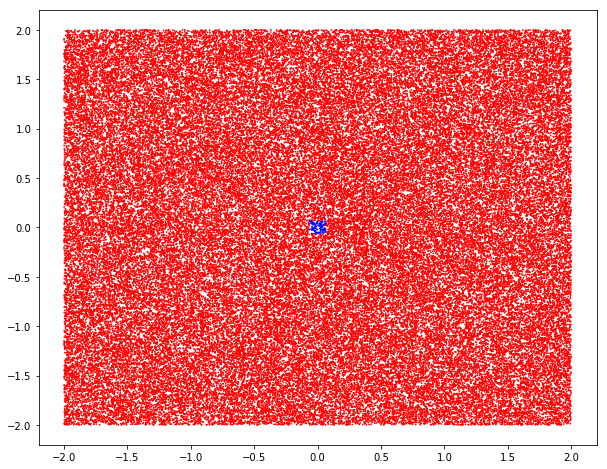

In [4]:
# DUMMY DATA
X = np.random.uniform(low=-2, high=2, size=(100000, 2))  # do not forget to standardize the data. For this distribution, it should be fine without it.
y = np.logical_and(np.abs(X[:, 0]) < 0.065, np.abs(X[:, 1]) < 0.065).astype('float') # final labels: -0.2 < X[:,0] < 0.2 AND -0.2 < X[:,1] < 0.2
#y = np.linalg.norm(X, axis=1) < 0.075
y_subspace = np.vstack([np.abs(X[:, 0]) < 0.1, np.abs(X[:, 1]) < 0.1]).T.astype('float')  # partial labels (for each subspace)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
plt.show()

In [3]:
#X, y = read_task('sdss_Q3_0.1%')

# NO FACTORIZATION EXAMPLE

iter: 0, fscore: 0.0031096063587090776, tsm: 0.0
iter: 5, fscore: 0.01616070080048331, tsm: 0.0
iter: 10, fscore: 0.03499018966644866, tsm: 0.0
iter: 15, fscore: 0.05385002516356316, tsm: 0.0
iter: 20, fscore: 0.058579881656804736, tsm: 0.0
iter: 25, fscore: 0.07345575959933222, tsm: 0.0
iter: 30, fscore: 0.11495754408883083, tsm: 0.0
iter: 35, fscore: 0.0, tsm: 0.0
iter: 40, fscore: 0.3940149625935162, tsm: 0.00011205737337516809
iter: 45, fscore: 0.15517241379310345, tsm: 0.00017042226850975194
iter: 50, fscore: 0.2459016393442623, tsm: 0.0004720840939132624
iter: 55, fscore: 0.7583333333333333, tsm: 0.0013465540457828376
iter: 60, fscore: 0.6580645161290323, tsm: 0.0027379075748776237
iter: 65, fscore: 0.8923076923076924, tsm: 0.006703161657915317
iter: 70, fscore: 0.7485380116959064, tsm: 0.031418753068237604
iter: 75, fscore: 0.8494623655913979, tsm: 0.2363013698630137
iter: 80, fscore: 0.7177700348432056, tsm: 0.29961089494163423
iter: 85, fscore: 0.8203125, tsm: 0.37117903930131

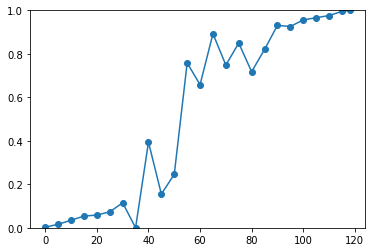

In [5]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 150  # number of points to be labeled by the user
SUBSAMPLING = float('inf') #10000, 50000, float('inf')
INITIAL_SAMPLER = StratifiedSampler(pos=1, neg=1)  # start with one random positive sample and one random negative sample
CALLBACK = [classification_metrics('fscore'), three_set_metric]  # callback function to be called at the end of each iteration. Here, we compute the current f-score
CALLBACK_SKIP = 5
PRINT_CALLBACK_RESULT = True

explore = PoolBasedExploration(NUMBER_OF_ITERATIONS, INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT)

# CHOOSE AN ALGORITHM
#learner = RandomSampler(SVC(C=1e5, kernel='rbf'))  # choose a random point
learner = SimpleMargin(C=1024, kernel='rbf')  # choose point closest to SVM decision boundary
#learner = KernelQueryByCommittee(kernel='rbf', sampling='deterministic', n_samples=8, warmup=100, thin=10, rounding=True)  # version space algorithm
learner = DualSpaceModel(learner, sample_unknown_proba=0.5)  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, y, learner, repeat=1)  # 'repeat' specifies how many times to repeat the exploration process

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
avg.plot(ylim=[0,1], marker='o')
plt.show()

# FACTORIZATION EXAMPLE

iter: 0, fscore: 0.00978656156584985, tsm: 0.0
iter: 5, fscore: 0.26547685443390967, tsm: 0.0
iter: 10, fscore: 0.6268292682926829, tsm: 0.21568627450980393
iter: 15, fscore: 0.7547723935389133, tsm: 0.515695067264574
iter: 20, fscore: 0.8012618296529969, tsm: 0.6501305483028721
iter: 25, fscore: 0.9861932938856016, tsm: 0.8896797153024911
iter: 30, fscore: 0.99609375, tsm: 0.9205776173285198
iter: 34, fscore: 1.0, tsm: 1.0


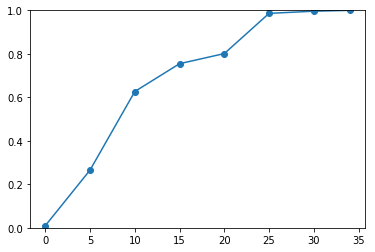

In [6]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 150  # number of points to be labeled by the user
SUBSAMPLING = float('inf') #10000, 50000, float('inf')
INITIAL_SAMPLER = StratifiedSampler(pos=1, neg=1)  # start with one random positive sample and one random negative sample
CALLBACK = [classification_metrics('fscore'), three_set_metric]  # callback function to be called at the end of each iteration. Here, we compute the current f-score
CALLBACK_SKIP = 5
PRINT_CALLBACK_RESULT = True

explore = PoolBasedExploration(NUMBER_OF_ITERATIONS, INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT)

# SUBSPATIAL LEARNER - run Simple Margin in each subspace
subspatial_active_learners = [
    KernelQueryByCommittee(kernel='rbf', n_samples=8, warmup=100, thin=10, sampling='deterministic'),
    KernelQueryByCommittee(kernel='rbf', n_samples=8, warmup=100, thin=10, sampling='deterministic'),
]

learner = SubspaceLearner(
    partition=[[0], [1]],  # partition of attributes (one subspace with the attribute 0, and another with 1)
    learners=subspatial_active_learners, 
    #label_function='AND', probability_function='min', ranking_function='square'
)

learner = DualSpaceModel(SimpleMargin(C=1024, kernel='rbf'), sample_unknown_proba=0.5, partition=[[0], [1]])  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, y_subspace, learner, repeat=1)  # use y_subspace here

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
avg.plot(ylim=[0,1], marker='o')
plt.show()